In this notebook we do full fine-tuning of Gemma model.

# PREREQUISITES:

In [4]:
from transformers import GemmaTokenizerFast, GemmaForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback, DataCollatorWithPadding
import torch
import pandas as pd
import numpy as np
from huggingface_hub import login
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import TrainerCallback
import os
import matplotlib.pyplot as plt

In [2]:
login("hf_gmCnYRCSgvHUgPxlZQgDufPzDGkDeSSUfuy")

# Load dataset

In [3]:
current_directory = os.getcwd() # get current directory
file_path = os.path.join(current_directory, '..', '..', 'data', 'processed', 'clean_data.csv') # navigate to folder with preprocessed data
data = pd.read_csv(file_path)
print(data.head(5))

                                        heading_text  bias_rating
0  chicago gun violence spikes and increasingly f...            0
1  'bullets just came from nowhere': fourth of ju...            1
2  dozens of shootings across us mark bloody july...            2
3  federal government will run out of cash on oct...            2
4  yellen tells congress that u.s. will run out o...            0


# Split and tokenize

In [ ]:
X = data['heading_text'].values
y = data['bias_rating'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
tokenizer = GemmaTokenizerFast.from_pretrained('google/gemma-2b')
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=512)

In [ ]:
class NewsDataset(torch.utils.data.Dataset):
    """
    We need this class to manage and load
    encoded inputs and corresponding labels into a format compatible
    with PyTorch's DataLoader for model training and evaluation :)
    """
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encodings, y_train)
test_dataset = NewsDataset(test_encodings, y_test)

# Load model and fine-tune it

In [4]:
model_id  = "google/gemma-2b-it"
device = 0 if torch.cuda.is_available() else -1

model = GemmaForSequenceClassification.from_pretrained(
    model_id, 
    num_labels = 3,
    ).to(device)

In [ ]:
total_layers = len(list(model.parameters()))
trainable_layers = int(total_layers * 0.5)  # The last 50% of layers

In [5]:
id2label = {0: "left", 1: "center", 2: "right"}
label2id = {"left": 0, "center": 1, "right":2}

In [6]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [ ]:
# a callback class to log metrics after each epoch and save them to a CSV file
class LogMetricsCallback(TrainerCallback):
    def __init__(self, log_dir, csv_filename="gemma_fine_tuned.csv"):
        super().__init__()
        self.log_dir = log_dir
        self.csv_filepath = os.path.join(log_dir, csv_filename)
        
        # Ensure the log directory exists
        os.makedirs(log_dir, exist_ok=True)
        if not os.path.exists(self.csv_filepath): # initialize CSV file with headers if it doesn't exist
            pd.DataFrame(columns=["epoch", "accuracy", "precision", "recall", "f1"]).to_csv(self.csv_filepath, index=False)

    def on_epoch_end(self, args, state, control, **kwargs):
        # Access the metrics from the state
        metrics = state.log_history[-1]  # Last entry should be the current epoch
        epoch = metrics.get("epoch") # Extract the current epoch number
        
        # Extract evaluation metrics
        accuracy = metrics.get("eval_accuracy")
        precision = metrics.get("eval_precision")
        recall = metrics.get("eval_recall")
        f1 = metrics.get("eval_f1")
        
        # Append metrics to CSV
        pd.DataFrame([{
            "epoch": epoch,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1
        }]).to_csv(self.csv_filepath, mode='a', header=False, index=False)
        
        print(f"Metrics for epoch {epoch} saved to {self.csv_filepath}")


In [7]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [7]:
torch.cuda.empty_cache()

In [10]:
# Freeze the earlier layers
for i, param in enumerate(model.parameters()):
    if i < (total_layers - trainable_layers):  # Freeze 50% of the layers
        param.requires_grad = False
    else:
        param.requires_grad = True  # Keep the last 50% trainable

In [12]:
training_args = TrainingArguments(
    output_dir='./results_gemma_fine_tune',
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./results_gemma_fine_tune',
    logging_steps=10,
    learning_rate=5e-6,
    save_total_limit=2,
    load_best_model_at_end=True
)

log_dir = os.path.join(current_directory, '..', '..', 'results')

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator = data_collator,
    compute_metrics=compute_metrics,
    callbacks=[
    LogMetricsCallback(log_dir=log_dir),           # save metrics
    EarlyStoppingCallback(early_stopping_patience=0)  # early stopping
]
)

trainer.train()

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


# Evaluate fine-tune model

In [ ]:
eval_results = trainer.evaluate()
print("Fine-tune performance:", eval_results)

# Train and Test loss graph

   Epoch  Training Loss  Validation Loss  Accuracy  Precision    Recall  \
0      1         0.9987         1.001748  0.456197   0.514158  0.456197   
1      2         0.8002         0.890461  0.551738   0.555130  0.551738   
2      3         0.7501         0.860871  0.569735   0.560030  0.569735   

         F1  
0  0.423425  
1  0.520140  
2  0.550050  


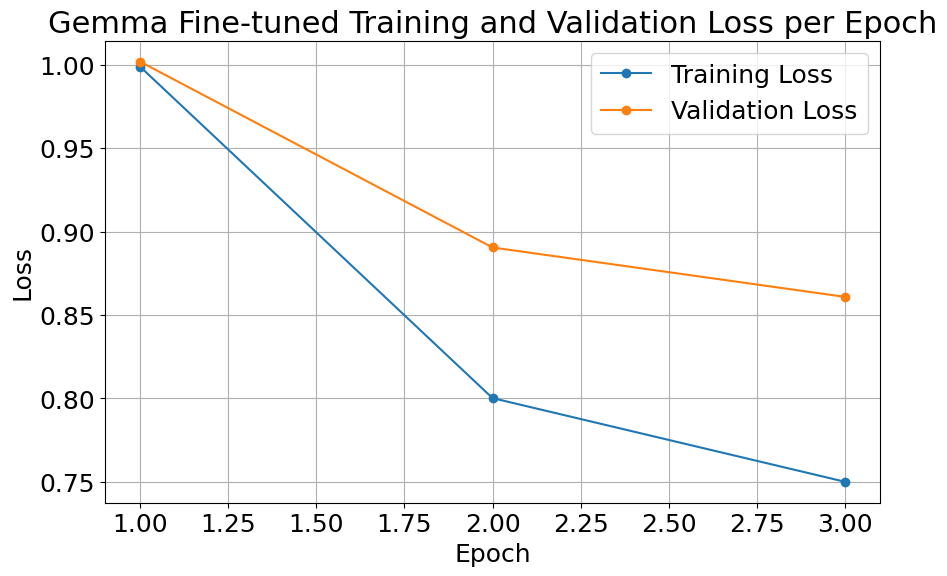

In [7]:
file_path = os.path.join(current_directory, '..', '..', 'results', 'gemma_fine_tune.csv') # navigate to folder with results
data_to_plot = pd.read_csv(file_path)
print(data_to_plot.head(3))

plt.figure(figsize=(10, 6))
plt.plot(data_to_plot['Epoch'], data_to_plot['Training Loss'], label='Training Loss', marker='o')
plt.plot(data_to_plot['Epoch'], data_to_plot['Validation Loss'], label='Validation Loss', marker='o')
plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Loss", fontsize=18)
plt.title("Gemma Fine-tuned Training and Validation Loss per Epoch", fontsize=22)

# Set legend font size
plt.legend(fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.grid(True)
plt.show()